# QPoland Global Quantum Hackathon
19-Oct-2024 to 27-Oct-2024 (For QML track submission deadline extended till 18-Nov-2024)

https://www.qaif.org/contests/qpoland-global-quantum-hackathon

**Team name**:  Qudit Creons

## Problem Statement:
### Quantum Machine Learning: Solving Linear Systems of Equations
### Re-Implementation of Variational Quantum Linear Solver from paper [Bravo-Prieto et al. (2020)](https://arxiv.org/pdf/1909.05820.pdf)

### Background

Linear systems of equations are fundamental in mathematics and have wide-ranging applications across several fields, including physics, engineering, economics, and computer science. This kind of equation can be found when solving numerically differential equations, analyzing electrical circuits, or performing 3D transformations in computer vision. Additionally, linear systems are critical in statistical analysis, particularly in regression models, which are used to find the best-fit line for data. Their importance lies in their simplicity, versatility, and ability to provide solutions in many practical scenarios.

Considering this, solving a linear system that grows in size becomes more difficult using classical computing techniques. In particular, Carlos Bravo-Prieto et al.'s paper "Variational Quantum Linear Solver" Ref[1] shows a solution to this problem using quantum machine learning methods.


### Detailed Challenge Description

In this challenge, your goal is to reproduce the implementation of the quantum algorithm displayed in **the Sec. 2.3 of the paper Ref [1]**, i.e. solve the following system of linear equations:
 $$\textbf{A}\vec{x}= \vec{0}$$

 $$A = \sum_{i=1}^{10} X_i  + 0.1\sum_{i=1}^{9} Z_i Z_{i+1} +I,$$


Where $ X_i$, adn $Z_i$ are the respective Pauli matrices, acting over the Qubit with index $i$.
The submitted solution to this challenge consists of a quantum program written with Classiq that includes:

	1) A correct cost function and quantum ansätze 
	2) A single execution of the quantum algorithm, using the state-vector simulator
	3) The quantum program’s CX-gate count


#### Requirements:

1) Install ***Python 3.12*** (NOTE - The Classiq SDK is currently supported for Python versions 3.8 to 3.12).
2) Install  ***Jupyter*** (Optional for SDK, required to run this notebook)
3) User registration at platform. **Note**: To use Classiq platform for free for non-commercial purposes, you must register. Then you can optionally install the Python SDK package and authenticate your account. [Click here for more derail...](https://docs.classiq.io/latest/classiq_101/registration_installations/)
4) Install  ***Classiq 0.57*** (Classiq's Python SDK for quantum computing)  [https://platform.classiq.io/](https://platform.classiq.io/)
5) Once above four steps completed "Authenticate the device with your Classiq account" as mentioned in step 3 link.

### Solution Development

**Disclaimer**: For developing solution we have used "[Variational Quantum Linear Solver (VQLS) with Linear Combination of Unitaries (LCU) Block Encoding.](https://docs.classiq.io/latest/explore/algorithms/vqls/lcu_vqls/vqls_with_lcu/)" Ref[4]. Here it is solution for 3 qubit. We developped solution for 10 qubits. Some portion we copied as it is from Ref[4]. We worked on "LCU Block Encoding" and Ansats as for 10 qubit solutions.

The Variational Quantum Linear Solver (VQLS) is a quantum algorithm that harnesses the power of Variational Quantum Eigensolvers (VQE) to efficiently solve systems of linear equations:

* **Input:** A matrix $\textbf{A}$ and a known vector $|\textbf{b}\rangle$.

* **Output:** An approximation of a normalized solution  $|x\rangle$ proportional to $|\textbf{x}\rangle$, satisfying the equation $\textbf{A} |\textbf{x}\rangle = |\textbf{b}\rangle$.

***


While the output of VQLS mirrors that of the HHL Quantum Linear-Solving Algorithm, VQLS distinguishes itself by its ability to operate on Noisy Intermediate-Scale Quantum (NISQ) computers. In contrast, HHL necessitates more robust quantum hardware and a larger qubit count, despite offering a faster computation speedup.

In this tutorial we will cover an implementation example of a **Variational Quantum Linear Solver** [[1](#VQLS)] using block encoding , in particular, we will use linear combinations of unitaries, or LCUs for short, for the block encoding **for 10 qubits**

As all variational algorithms, the VQLS is a hybrid algorithm in which we apply a classical optimization on the results of a parametrized (ansatz) quantum program

### Quantum Part: Variational Circuit

To block encode a Variational Quantum Linear Solver as explained above we can define a high-level `block_encoding_vqls` function as follows:

In [1]:
from typing import List
import numpy as np
from classiq import *

In [2]:
@qfunc
def block_encoding_vqls(
    ansatz: QCallable,
    block_encoding: QCallable,
    prepare_b_state: QCallable,
) -> None:
    ansatz()
    block_encoding()
    invert(lambda: prepare_b_state())

From here, all we need to do is to define our `ansatz`, `block_encoding` and `prepare_b_state` to fit the above specific example and we are ready to build our model, synthesize it, execute it and analyze the results.

### Classical Optimizer: Finding Optimal Parameters


In order to variationally solve our linear problem, we define the
cost function $C = 1- |\langle b | \Psi \rangle|^2$ that we are going to
minimize. 

At high level, the above could be implemented as follows:

We construct a quantum model as depicted in the figure below. When measuring the above circuit in the computational basis, the probability of
finding the system qubits it in the ground state (given the ancillary qubits measured
in their ground state), is
    $|\langle 0 | U_b^\dagger |\Psi \rangle|^2 = |\langle b | \Psi \rangle|^2$

We define a classical function that gets the quantum program, minimizes the cost function using the COBYLA optimizer, and returns the optimal parameters.

In [3]:
import random

import matplotlib.pyplot as plt
from scipy.optimize import minimize

from classiq.execution import ExecutionSession


class VqlsOptimizer:
    def __init__(self, qprog, ansatz_param_count, ansatz_var_name, aux_var_name):
        self.qprog = qprog
        self.ansatz_param_count = ansatz_param_count
        self.ansatz_var_name = ansatz_var_name
        self.aux_var_name = aux_var_name
        self.es = ExecutionSession(qprog)
        self.intermediate = {}

    def get_cond_prop(self, res):
        aux_prob_0 = 0
        all_prob_0 = 0
        for s in res:
            if s.state[self.aux_var_name] == 0:
                aux_prob_0 += s.shots
                if s.state[self.ansatz_var_name] == 0:
                    all_prob_0 = s.shots
        return all_prob_0 / aux_prob_0

    def my_cost(self, params):
        results = self.es.sample(params)
        return 1 - self.get_cond_prop(
            results.parsed_counts_of_outputs([self.ansatz_var_name, self.aux_var_name])
        )

    def f(self, x):
        cost = self.my_cost(
            {"params_" + str(k): x[k] for k in range(self.ansatz_param_count)}
        )
        self.intermediate[tuple(x)] = cost
        return cost

    def optimize(self):
        random.seed(1000)
        out = minimize(
            self.f,
            x0=[
                float(random.randint(0, 3000)) / 1000
                for i in range(0, self.ansatz_param_count)
            ],
            method="COBYLA",
            options={"maxiter": 2000},
        )
        print(out)
        out_f = [out["x"][0 : self.ansatz_param_count]]
        print(out_f)
        plt.plot(
            [l for l in range(len(self.intermediate))], list(self.intermediate.values())
        )

        return {
            "params_" + str(k): list(self.intermediate.keys())[-1][k]
            for k in range(self.ansatz_param_count)
        }

***
Once the optimal variational weights `w` are found, we
can generate the quantum state $|x\rangle$. By measuring $|x\rangle$ in
the computational basis we can estimate the probability of each basis
state.
***

## LCU Block Encoding: Block encoding the matrix A with LCU

We treat a specific example based on a system of 10 qubits:

$$A = \sum_{i=1}^{10} X_i  + 0.1\sum_{i=1}^{9} Z_i Z_{i+1} +I,$$


where $Z_i, X_i, H_i$ represent the Pauli $Z$, Pauli $X$ and Hadamard gates applied to the qubit with index $i$.

Our first goal is to encode the Matrix A on a quantum circuit.  

Using *linear combinations of unitaries* (LCU) we can encode the operator A

$A$, representable as a linear combination of $L$ unitary matrices $A_0, A_1, \dots, A_{L-1}$ we can implement a quantum circuit that applies the associated operator.

$$A = \sum_{i=1}^{10} X_i  + 0.1\sum_{i=1}^{9} Z_i Z_{i+1} +I,$$

where $c_l$ are arbitrary complex numbers. Crucially, we assume that each unitary $A_l$ can be efficiently implemented using a quantum circuit acting on $n$ qubits.

First we will need to define some unitary operations associated to the simple example presented above.

Let's apply the previous theory on our simple example based on a system of 10 qubits:

In [4]:
paulis = []
num_qubits=10
# X terms
for i in range(num_qubits):
    pauli_str = ['I'] * num_qubits
    pauli_str[i] = 'X'
    paulis.append((''.join(pauli_str),1.0))
    
# ZZ terms
for j in range(num_qubits - 1):
    pauli_str = ['I'] * num_qubits
    pauli_str[j] = 'Z'
    pauli_str[j+1] = 'Z'
    paulis.append((''.join(pauli_str),0.1))

# I term
for k in range(10):
    pauli_str = ['I'] * num_qubits
    paulis.append((''.join(pauli_str),1.0))
# additional pading with zero
for k in range(3):
    pauli_str = ['I'] * num_qubits
    paulis.append((''.join(pauli_str),0.0))

In [5]:
num_system_qubits = 10
num_ancila_qubits = 5
ansatz_param_count = 28


error_bound = 0.0
error_metric = "LOSS_OF_FIDELITY"

To block encode the A we need only 3 thing:
1. Representing it as a linear combination of $L$ unitary matrices (in our case we will use Pauli matrices)]
2. A a unitary circuit $U_c$ that embeds the square root of $c$ (linear combination coefficients) into the quantum state
3. A circuit that encodes $CA_l$

#### Preparing $U_c$  
To construct $\vec{c}$ from the above example we will we want to apply our Pauli's strings decomposition. For this we need  additional functions:

In [6]:
from typing import cast

from classiq import Pauli, PauliTerm

my_list = {"I": Pauli.I, "X": Pauli.X, "Y": Pauli.Y, "Z": Pauli.Z}


def pauli_str_to_enums(pauli):
    return [my_list[s] for s in pauli]


def pauli_operator_to_hamiltonian(pauli_list):
    return [
        PauliTerm(
            pauli=pauli_str_to_enums(pauli), coefficient=cast(complex, coeff).real
        )
        for pauli, coeff in pauli_list
    ]

Now we can construct $\vec{c}$:

In [7]:
pauli_terms_structs = pauli_operator_to_hamiltonian(paulis)
c = []
for pauli_struct in pauli_terms_structs:
    c.append(pauli_struct.coefficient)
c = c / np.sum(c)

To prepare $U_c$ we need to embed the square root of the probability distribution `c`
into the amplitudes of the ancillary state:

In [8]:
@qfunc
def prepare_c(ancillary_qubits: QArray[QBit]):
    inplace_prepare_state(list(c), error_bound, ancillary_qubits)

#### LCU sequence of all controlled-unitaries $CA_l$

Next, we are left to define the LCU sequence of all controlled-unitaries $CA_l$,
acting as $A_l$ on the system whenever the ancillary state is
$|l\rangle$. 
The `prepare_ca` function iterates over a list of Pauli terms $A_l$ and will apply $CA_l$ on the 10 qubit state `phi` controlled by the ancillary state $\vec{c}$ 

In [9]:
@qfunc
def apply_pauli(pauli_value: CInt, qubit: QBit):
    switch(
        pauli_value,
        [lambda: IDENTITY(qubit), lambda: X(qubit), lambda: Y(qubit), lambda: Z(qubit)],
    )


@qfunc
def apply_pauli_term(pauli_term: PauliTerm, x: QArray[QBit]):
    repeat(
        count=x.len,
        iteration=lambda index: apply_pauli(pauli_term.pauli[index], x[index]),
    )


@qfunc
def apply_controlled_pauli_term(pauli_term: PauliTerm, x: QArray[QBit]):
    repeat(
        count=x.len,
        iteration=lambda index: apply_pauli(pauli_term.pauli[index], x[index]),
    )


@qfunc
def prepare_ca(
    pauli_terms_list: CArray[PauliTerm],
    system_qubits: QArray[QBit],
    ancillary_qubits: QNum,
):
    repeat(
        count=pauli_terms_list.len,
        iteration=lambda i: control(
            ancillary_qubits == i,
            lambda: apply_pauli_term(pauli_terms_list[i], system_qubits),
        ),
    )

### Preparing Ansatz

Let's consider our ansatz $V(w)$, such that : 

$$|x\rangle = V(w) |0\rangle $$


This allows us to "search" the state space by varying some set of parameters, $w$. 

The ansatz that we will use for this 10 qubits system implementation takes in 28 parameters as defined in `apply_fixed_10_qubit_system_ansatz` function:

In [10]:
@qfunc
def apply_ry_on_all(params: CArray[CReal], io: QArray[QBit]):
    repeat(count=io.len, iteration=lambda index: RY(params[index], io[index]))


@qfunc
def apply_fixed_10_qubit_system_ansatz(
    angles: CArray[CReal], system_qubits: QArray[QBit]
):
    apply_ry_on_all(angles[0:num_system_qubits], system_qubits)
    base_ang=num_system_qubits
    for i in range(num_system_qubits-1):        
        if ((i % 2) != 0):    
            CZ(system_qubits[i], system_qubits[i+1])            
            RY(angles[base_ang], system_qubits[i])            
            base_ang+=1           
            RY(angles[base_ang], system_qubits[i+1])            
            base_ang+=1
            
    for i in range(num_system_qubits-1):        
        if ((i % 2) == 0):
            CZ(system_qubits[i], system_qubits[i+1])
    
    base_ang_e=base_ang+num_system_qubits

    apply_ry_on_all(angles[base_ang:base_ang_e], system_qubits)
    

This is a fixed hardware ansatz: the configuration of quantum gates remains the same for each run of the circuit, all that changes are the parameters. The applications of $Ry$ gates allow us to search the state space, while the $CZ$ gates create "interference" between the different qubit states.

### Alternate Ansatz
Using only $Ry$ gates i.e. not used the $CZ$ layer

     apply_ry_on_all(angles, system_qubits)

assign correct paramters value to , i.e. ansatz_param_count = 10

### Running the VQLS

Now, we can define the main function: we call `block_encoding_vqls` with the arguments of our specific example.

In [11]:
@qfunc
def main(
    params: CArray[CReal, ansatz_param_count],
    ancillary_qubits: Output[QNum],
    system_qubits: Output[QNum],
):

    allocate(num_ancila_qubits, ancillary_qubits)
    allocate(num_system_qubits, system_qubits)

    block_encoding_vqls(
        ansatz=lambda: apply_fixed_10_qubit_system_ansatz(params, system_qubits),
        block_encoding=lambda: within_apply(
            within=lambda: prepare_c(ancillary_qubits),
            apply=lambda: prepare_ca(
                pauli_terms_structs, system_qubits, ancillary_qubits
            ),
        ),
        prepare_b_state=lambda: apply_to_all(H, system_qubits),
    )

Constructing the model, synthesizing and executing on Classiq's simulator:

In [12]:
from classiq.execution import ClassiqBackendPreferences, ExecutionPreferences
from classiq.synthesis import set_execution_preferences

backend_preferences = ClassiqBackendPreferences(backend_name="simulator_statevector")
model = create_model(main)

model = set_execution_preferences(
    model,
    execution_preferences=ExecutionPreferences(
        num_shots=2048, job_name="vqls_with_lcu_10Qbit", backend_preferences=backend_preferences
    ),
)
qprog = synthesize(model)
show(qprog)

Opening: https://platform.classiq.io/circuit/0f9ac94b-89c9-49ec-a1c5-668c11e07457?version=0.57.0


In [13]:
from classiq import write_qmod

write_qmod(model, name="vqls_with_lcu_10Qbit", decimal_precision=15)

We run the classical optimizer to get the optimal parameters

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 0.04019823788546251
       x: [ 7.669e-01  3.175e+00 ...  1.704e+00  5.242e-02]
    nfev: 352
   maxcv: 0.0
[array([0.7669234 , 3.1752262 , 0.54619642, 3.01106404, 0.81217   ,
       1.04621954, 3.03704237, 3.125401  , 2.00862933, 1.54680304,
       0.06192385, 1.24050983, 3.80091389, 1.39688818, 1.19229511,
       3.76053945, 2.66577454, 2.02577354, 2.18012252, 4.57966647,
       1.0331208 , 1.10921541, 0.89111932, 1.62661007, 1.0481476 ,
       1.9410607 , 1.70425857, 0.05241772])]


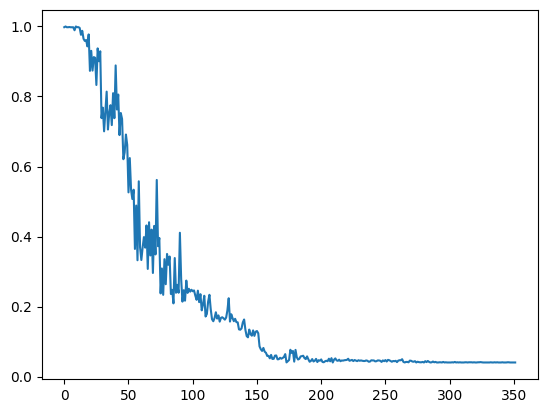

In [14]:
optimizer = VqlsOptimizer(
    qprog, ansatz_param_count, "system_qubits", "ancillary_qubits"
)
optimal_params = optimizer.optimize()

#### Time Taken to complete: Start time: 10:10  End time: 17:20 ---- Total time taken 7 Hours 10 minutes

## CX-gate count

In [15]:
circuit = QuantumProgram.from_qprog(qprog)
cx_counts=circuit.transpiled_circuit.count_ops["cx"]
print(f"Number of CX Gates: {cx_counts}")

#circuit.data

Number of CX Gates: 3586


### Measuring the Quantum Solution

Finally, we can apply the optimal params to measure the quantum results for $\vec{x}$:

In [16]:
@qfunc
def main(io: Output[QArray[QBit]]):
    allocate(num_system_qubits, io)
    apply_fixed_10_qubit_system_ansatz(list(optimal_params.values()), io)

In [17]:
from classiq.execution import ClassiqBackendPreferences, ExecutionPreferences
from classiq.synthesis import set_execution_preferences

backend_preferences = ClassiqBackendPreferences(backend_name="simulator_statevector")
qmod = create_model(main)

qmod = set_execution_preferences(
    qmod,
    execution_preferences=ExecutionPreferences(
        num_shots=2048, job_name="vqls_with_lcu_10Qbit", backend_preferences=backend_preferences
    ),
)


qprog = synthesize(qmod)

In [18]:
job = execute(qprog)
results = job.result()[0]

In [19]:
state_vector = results.value.state_vector

In [24]:
probabilities = []
for key, val in state_vector.items():
    probabilities.append(abs(complex(val)) ** 2)


probabilities[0:20]

[0.00047749715666810824,
 0.0003231724403471997,
 0.0003714677530577092,
 0.00029670558309079806,
 0.0013053690730441352,
 0.0008243329901252833,
 0.0010294120863271756,
 0.0008893617195799956,
 0.0013972644768662976,
 0.0009187198100933298,
 0.0010932596230165325,
 0.0009030589241086983,
 0.0007017309493726455,
 0.00045445109365615437,
 0.000550689237786297,
 0.0004627431160155046,
 0.0007607260914856596,
 0.0005114921891756966,
 0.0005925828047028221,
 0.0004769963087704867]

In [23]:
amplitudes = []
for key, val in state_vector.items():
    amplitudes.append(abs(complex(val)))


amplitudes[0:20]

[0.021851708323792633,
 0.017976997534271393,
 0.019273498723836033,
 0.01722514392075718,
 0.03612989168326049,
 0.028711199733297166,
 0.03208445240809286,
 0.029822168257522718,
 0.03738000102817411,
 0.03031039112405727,
 0.03306447675401098,
 0.030050938822417817,
 0.026490204781629105,
 0.02131785856168847,
 0.023466768797307757,
 0.02151146475755439,
 0.02758126341351425,
 0.02261619307433717,
 0.024343023737876567,
 0.02184024516278347]

## References

<a name='VQLS'>[1]</a>: [Bravo-Prieto et al.,Variational Quantum Linear Solver. (2020)](https://arxiv.org/pdf/1909.05820.pdf)

[2]:	The Hamiltonian Simulation Guides using Classiq

[3]:	The Quantum Machine Learning Guide using Classiq

<a name='VQLS-with-LCU'>[4]</a>: [Variational Quantum Linear Solver (VQLS) with Linear Combination of Unitaries (LCU) Block Encoding.](https://docs.classiq.io/latest/explore/algorithms/vqls/lcu_vqls/vqls_with_lcu/)

#### Classiq resources:

1.	[Getting Started with Classiq - Classiq 101](https://docs.classiq.io/latest/classiq_101/)
  
3.	[Classiq’s documentation](https://docs.classiq.io/latest/)
  
5.	[Classiq Library](https://docs.classiq.io/latest/explore/) of many implementation algorithms and applications

7.	[Classiq Community Slack](https://short.classiq.io/join-slack) is available for any questions you might have